In [9]:
### imports
import numpy as np
import pandas as pd
import ast
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.base import clone
from sklearn.kernel_approximation import Nystroem
from sklearn.svm import SVR

import sys

sys.path.append("..")
sys.path.append("../src")

from src.datahandling.loading import load_data  # loading
import src.datahandling.visualization as vis  # plotting
from src.models.regression import * # models
from src.datahandling.preprocessing import * # preprocessing
from utils import powerset

### load benchmarks
benchmarks = pd.read_csv("../results/benchmarks.csv")

# Regression Variants

Regression is a supervised learning algorithm that tries to find a (linear) relationship between a dependent variable and one or more independent variables by solving an optimization problem. In contrast to the _Moving Average_ model we are able to exploit additional variables in the datasets, such as wind speed. Within this project we tested the following regression variants:

1. __Ridge Regression__

2. __Lasso Regression__

3. __Kernel Ridge Regression__:

Please find a description of the regression variants in their respective sections. 
Each section follows a consistent structure, with the only variation being specific to the analysis. First, we conduct a grid search across the hyperparameter space. Subsequently, we plot and analyse the results. At the end of each section, we retrain the top-performing models and examine how their predictions compare to the actual ground truth values.

__Remarks to the computational complexity:__

The computational complexity of the all implemented regression variants is $O(m^3)$, where $m$ is the number of features. In our case we have several hyperparameters that influence $m$. First, we have the number of chosen features from the dataset. Second, we have the window size. Third, we might want to add polynomial features. So its possible that we run into computational problems if we choose too many features or a too large window size.

We begin with loading the data:


#### Data Loading 

In [10]:
### loading british data
TURBINE_ID_BRIT = 2 
data_british = load_data(turbine_id=TURBINE_ID_BRIT, which_data="British")#

### loading brazilian data
TURBINE_ID_BRAZ = 1
data_braz = load_data(turbine_id=TURBINE_ID_BRAZ, which_data="Brazilian")

### cleaning british data
cleaner = DataCleaner(
    features=[
        "Power (kW)",
        "Wind speed (m/s)",
        "Wind direction (°)",
        "Nacelle position (°)",
        "Nacelle ambient temperature (°C)",
        "Rotor speed (RPM)",
    ],
    rename_features=[
        "power",
        "wind_speed",
        "wind_direction",
        "nacelle_position",
        "nacelle_temp",
        "rotor_speed",
    ],
)
data_british = cleaner.transform(data_british)

### cleaning brazilian data
cleaner = DataCleaner(
    features=[
        "active_power_total",
        "wind_speed",
        "wind_direction",
        "rotor_rpm",
        "air_density",
        "relative_humidity",
    ],
    rename_features=[
        "power",
        "wind_speed",
        "wind_direction",
        "rotor_speed",
        "air_density",
        "relative_humidity",
    ],
)
data_braz = cleaner.transform(data_braz)

Also we can define the final test and training datasets beforehand:

In [11]:
### create train and test set for british dataset (exactly as used in the benchmarks)
test_start_brit = benchmarks["test_start"][0]
test_end_brit = benchmarks["test_end"][0]
X_train_brit, y_train_brit, X_test_brit, y_test_brit = train_test_split(
    df=data_british, test_start=test_start_brit, test_end=test_end_brit, target_var="power"
)

### create train and test set for brazilian data (exactly as used in the benchmarks)
test_start_braz = benchmarks["test_start"][3]
test_end_braz = benchmarks["test_end"][3]
X_train_braz, y_train_braz, X_test_braz, y_test_braz = train_test_split(
    df=data_braz, test_start=test_start_braz, test_end=test_end_braz, target_var="power"
)

## Ridge Regression

The ridge regression model adds a regularization term to the L2-loss function. The regularization term is defined as the L2-norm of the weight vector $\omega$. So we have the following optimization problem:

$$
\min_{\omega} ||Y - X\omega||^2 + \lambda ||\omega||^2
$$

We can solve this optimization problem in closed form:

$$
\omega = (X^TX + \lambda I)^{-1}X^TY
$$

In [12]:
### Define model
model = Pipeline(
    [
        ("fs", FeatureSelector()),
        ("st", SupervisedTransformer()),
        ("est", RidgeRegression()),
    ]
)

### Define the hyperparameter grid
# We only consider feature sets that contain "power", since we saw in the Moving Average that this is a very predictive feature
feature_sets = [fs for fs in powerset([
        "power",
        "wind_speed",
        "wind_direction",
        "nacelle_position",
        "nacelle_temp",
        "rotor_speed",
    ]) if "power" in fs]

param_grid = [
    {
    "fs__features": feature_sets,
    "st__horizon": ["10min"],
    "st__window_size": [1], # window size is chosen based on the results of the Moving Average model
    "est__alpha": [0, 0.1, 1, 10],
    },
    {
    "fs__features": feature_sets,
    "st__horizon": ["hourly"], 
    "st__window_size": [6],
    "est__alpha": [0, 0.1, 1, 10],
    },
    {
    "fs__features": feature_sets,
    "st__horizon": ["daily"],
    "st__window_size": [144],
    "est__alpha": [0, 0.1, 1, 10],
    }
]

### British Dataset - Kelmarsh

In [13]:
### hyperparameter tuning
### WARNING: LONG RUNTIME
### RUNTIME: ~ 3 hours 
do_gridsearch = False

X = data_british
y = data_british["power"]

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    cv=TimeSeriesSplit(n_splits=3),
    verbose=2,
    n_jobs=-1,
    refit=False,
)

if do_gridsearch:
    grid_search.fit(X, y)
    res_gs_brit = pd.DataFrame(grid_search.cv_results_)
    # store results in csv-file
    pd.DataFrame(res_gs_brit).to_csv("../results/results_gs_rr_brit.csv")
    # reload necessary because list of features is stored as string and can then be used as an index
    res_gs_brit = pd.read_csv("../results/results_gs_rr_brit.csv")
else:
    res_gs_brit = pd.read_csv("../results/results_gs_rr_brit.csv")

/Users/haraldkugler/miniconda3/envs/res_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


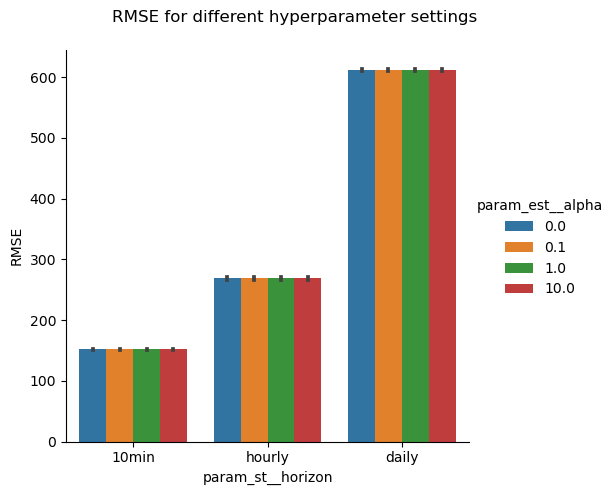

In [14]:
# plot gridsearch results
vis.plot_gridsearch_results(
    res_gs_brit, x="param_st__horizon", hue="param_est__alpha", col=None 
)

__Analysis:__

There are almost no differences between the tested models, i.e. they display similar RMSE values and variances. Interestingly, the variances is really small. This shows two things: First, training with a subset of all available data might be sufficient (since we take the errors of the respective folds into account -> have a look at the plotting function in `datahandling/visualization.py`). Second, the model does not really rely on the selected features (feature parameter is not displayed seperately in the plots). 

In [15]:
### extract best parameters of each model for each horizon
best_params_brit_rr = (
    res_gs_brit.set_index(["params"])[["mean_test_score", "param_st__horizon"]]
    .groupby("param_st__horizon")
    .idxmax()
)

# print best parameters for each horizon
for horizon in best_params_brit_rr.index:
    print(
        f"Best parameters for horizon {horizon}: {ast.literal_eval(best_params_brit_rr.loc[horizon][0])}"
    )

Best parameters for horizon 10min: {'est__alpha': 10, 'fs__features': ['power', 'wind_speed', 'nacelle_position', 'nacelle_temp'], 'st__horizon': '10min', 'st__window_size': 1}
Best parameters for horizon daily: {'est__alpha': 10, 'fs__features': ['power', 'wind_direction', 'nacelle_temp', 'rotor_speed'], 'st__horizon': 'daily', 'st__window_size': 144}
Best parameters for horizon hourly: {'est__alpha': 10, 'fs__features': ['power', 'wind_speed', 'nacelle_position', 'nacelle_temp'], 'st__horizon': 'hourly', 'st__window_size': 6}


In [16]:
### plot predictions for best models

# refit models
models = {}
predictions = {}
for horizon in ["10min", "hourly", "daily"]:
    models[horizon] = clone(model).set_params(
        **ast.literal_eval(best_params_brit_rr.loc[horizon][0])
    )
    models[horizon].fit(X_train_brit, y_train_brit)
    predictions[horizon] = models[horizon].predict(X_test_brit)
predictions = pd.DataFrame(predictions, index=X_test_brit.index)

# plot predictions
vis.plot_predictions(
    predictions,
    y_test_brit,
)


__Analysis:__

The plots resemble the ones from the _Moving Average_ model. 

- For a forecasting horizon of 10 minutes, the model is able to predict the ground truth values very well. If we choose fewer data points, we see that the model appears to have also a shift by exactly one time steps. In contrary to the _Moving Average_ model, this behaviour is not there by design of the model. 

- The _Ridge Regression_ model also shows similar results to the ones provided by the _Moving Average_. The model predicts the general structure of the ground truth values well, but does not capture sudden peaks or troughs.

- For a forecasting horizon of one day, the _Ridge Regression_ model deviates from the _Moving Average_ model the most. The curve is a very conservative estimate of the overall trend, but yet does not provide a smooth curve.

Since we observed the right shift, we have a look at the parameters of the first two models:

In [20]:
### extract coefficients of first two models
# horizon = 10min
print(models["10min"]["est"].coef_)

# horizon = hourly
print(models["hourly"]["est"].coef_)

[ 9.29479141e-01  9.73947074e+00  8.35878047e-03 -5.92338790e-01]
[ 4.85444209e-01  6.76610277e-02  7.83321775e-02  6.34365377e-02
  5.28714329e-02  8.35376093e-02  2.10199148e+01  2.45159595e+00
  1.26447142e+00 -2.13527991e+00 -1.45083059e+00  6.62793481e-01
 -3.16462320e-02 -2.06739542e-02 -4.47692297e-03 -1.04411931e-02
  1.73281695e-02  2.06730973e-02  4.93466780e+01 -3.40799858e+01
 -4.11714840e+00 -1.51570978e+00 -8.18389412e-01 -1.03062304e+01]


We do this because we want to see if other features than "power" are considered in the prediction, i.e. the corresponding coefficients are not zero. Since this is not the case we can reject this hypothesis. 

### Brazilian Dataset - Beberibe

In [26]:
### overwrite feature set for brazilian data 
for i in range(3):
    param_grid[i]["fs__features"] = [
        fs for fs in powerset([
            "power",
            "wind_speed",
            "wind_direction",
            "rotor_speed",
            "air_density",
            "relative_humidity",
        ]) if "power" in fs
    ]


In [27]:
### hyperparameter tuning
### RUNTIME: ~ 12 min
do_gridsearch = False

X = data_braz
y = data_braz["power"]

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    cv=TimeSeriesSplit(n_splits=3),
    verbose=2,
    n_jobs=-1,
    refit=False,
)

if do_gridsearch:
    grid_search.fit(X, y)
    res_gs_braz = pd.DataFrame(grid_search.cv_results_)
    # store results in csv-file
    pd.DataFrame(res_gs_braz).to_csv("../results/results_gs_rr_braz.csv")
    # reload necessary because list of features is stored as string and can then be used as an index
    res_gs_braz = pd.read_csv("../results/results_gs_rr_braz.csv")
else:
    res_gs_braz = pd.read_csv("../results/results_gs_rr_braz.csv")

Fitting 3 folds for each of 384 candidates, totalling 1152 fits


[CV] END est__alpha=0, fs__features=['power'], st__horizon=10min, st__window_size=1; total time=   0.1s
[CV] END est__alpha=0, fs__features=['power'], st__horizon=10min, st__window_size=1; total time=   0.1s
[CV] END est__alpha=0, fs__features=['power'], st__horizon=10min, st__window_size=1; total time=   0.1s
[CV] END est__alpha=0, fs__features=['power', 'wind_speed'], st__horizon=10min, st__window_size=1; total time=   0.1s
[CV] END est__alpha=0, fs__features=['power', 'wind_speed'], st__horizon=10min, st__window_size=1; total time=   0.1s
[CV] END est__alpha=0, fs__features=['power', 'wind_direction'], st__horizon=10min, st__window_size=1; total time=   0.2s
[CV] END est__alpha=0, fs__features=['power', 'wind_direction'], st__horizon=10min, st__window_size=1; total time=   0.2s
[CV] END est__alpha=0, fs__features=['power', 'wind_speed'], st__horizon=10min, st__window_size=1; total time=   0.2s
[CV] END est__alpha=0, fs__features=['power', 'wind_speed', 'wind_direction'], st__horizon

/Users/haraldkugler/miniconda3/envs/res_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


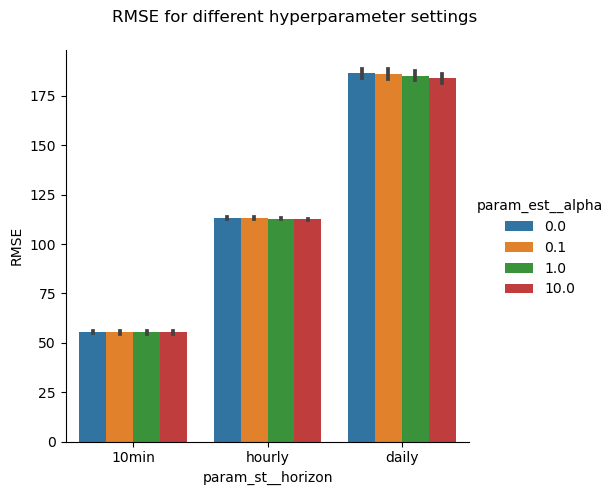

In [28]:
# plot gridsearch results
vis.plot_gridsearch_results(
    res_gs_braz, x="param_st__horizon", hue="param_est__alpha", col=None
)

In [29]:
### extract best parameters of each model for each horizon
best_params_braz_rr = (
    res_gs_braz.set_index(["params"])[["mean_test_score", "param_st__horizon"]]
    .groupby("param_st__horizon")
    .idxmax()
)

# print best parameters for each horizon
for horizon in best_params_braz_rr.index:
    print(
        f"Best parameters for horizon {horizon}: {ast.literal_eval(best_params_braz_rr.loc[horizon][0])}"
    )

Best parameters for horizon 10min: {'est__alpha': 10, 'fs__features': ['power', 'wind_speed', 'relative_humidity'], 'st__horizon': '10min', 'st__window_size': 1}
Best parameters for horizon daily: {'est__alpha': 10, 'fs__features': ['power', 'wind_speed', 'relative_humidity'], 'st__horizon': 'daily', 'st__window_size': 144}
Best parameters for horizon hourly: {'est__alpha': 10, 'fs__features': ['power', 'wind_speed'], 'st__horizon': 'hourly', 'st__window_size': 6}


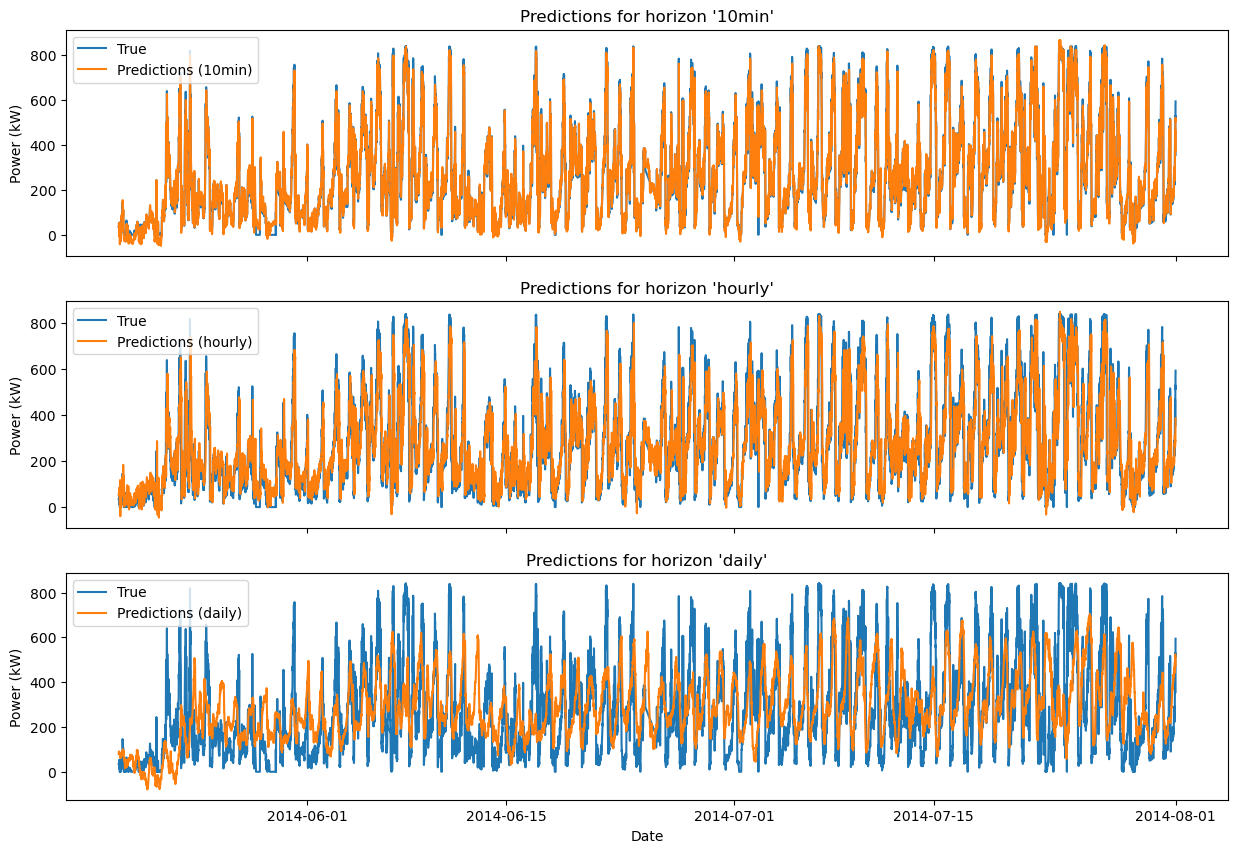

In [30]:
### plot predictions for best models

# refit models
models = {}
predictions = {}
for horizon in ["10min", "hourly", "daily"]:
    models[horizon] = clone(model).set_params(
        **ast.literal_eval(best_params_braz_rr.loc[horizon][0])
    )
    models[horizon].fit(X_train_braz, y_train_braz)
    predictions[horizon] = models[horizon].predict(X_test_braz)
predictions = pd.DataFrame(predictions, index=X_test_braz.index)

# plotting_braz
vis.plot_predictions(predictions, y_test_braz)

## Kernel Ridge Regression

The _Kernel Ridge Regression_ algorithm extends basic _Ridge Regression_ by using the kernel trick. The kternel trick allows us to implicitly map the input data into a higher dimensional feature space and thus to capture non-linear relationships. That is why we did not transform the data with the Polynomial feature transformer in the _Ridge Regression_. 

Mapping is done by defining a kernel function $k(x, x')$ that computes the inner product of the mapped feature vectors $\phi(x)$ and $\phi(x')$:

$$
k(x, x') = \phi(x)^T\phi(x')
$$

The kernel trick allows us to avoid the explicit computation of $\phi(x)$ and $\phi(x')$. Here we will use the _Gaussian Kernel_:

$$
k(x, x') = \exp(-\gamma||x - x'||^2)
$$

The optimization problem of _Kernel Ridge Regression_ is defined as follows:

$$
\min_{\omega} ||Y - \Phi\omega||^2 + \lambda ||\omega||^2
$$

where $\Phi$ is the kernel matrix with $\Phi_{ij} = k(x_i, x_j)$.

__Remarks to the computational complexity:__

The computational complexity of the _Kernel Ridge Regression_ is $O(m^2n)$, where $m$ is the number of features and $n$ is the number of samples. In our case this is a problem since we have a large number of samples. We use the Nystroem method to approximate the kernel matrix $\Phi$. The Nystroem method is a two-step process:

1. Randomly choose a subset of the training data $S = \{x_1, ..., x_l\}$ with $l << n$.

2. Compute the kernel matrix $\Phi_S$ for the subset $S$.



In [ ]:
### Define model
model = Pipeline(
    [
        ("fs", FeatureSelector()),
        ("st", SupervisedTransformer()),
        ("est", LassoRegression()),
    ]
)

### Define the hyperparameter grid
param_grid = {
    "fs__features": powerset(["power", "wind_speed", "wind_direction", "rotor_speed"])[1:],
    "st__horizon": ["10min", "hourly", "daily"],  # different tasks
    "st__window_size": [1, 6, 10],
    "est__alpha": [0.1, 1, 10],
}

### British Dataset - Kelmarsh

In [ ]:
### hyperparameter tuning
### RUNTIME: ~ 6 min
do_gridsearch = False

X = data_british
y = data_british["power"]

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    cv=TimeSeriesSplit(n_splits=3),
    verbose=1,
    n_jobs=-1,
    refit=False,
)

if do_gridsearch:
    grid_search.fit(X, y)
    res_gs_brit = pd.DataFrame(grid_search.cv_results_)
    # store results in csv-file
    pd.DataFrame(res_gs_brit).to_csv("../results/results_gs_kernel_brit.csv")
    # reload necessary because list of features is stored as string and can then be used as an index
    res_gs_brit = pd.read_csv("../results/results_gs_kernel_brit.csv")
else:
    res_gs_brit = pd.read_csv("../results/results_gs_kernel_brit.csv")

In [ ]:
# plot gridsearch results
vis.plot_gridsearch_results(
    res_gs_brit, x="param_est__alpha", hue="param_st__window_size", 
)

In [ ]:
### extract best parameters of each model for each horizon
best_params_brit_kernel = (
    res_gs_brit.set_index(["params"])[["mean_test_score", "param_st__horizon"]]
    .groupby("param_st__horizon")
    .idxmax()
)

# print best parameters for each horizon
for horizon in best_params_brit_kernel.index:
    print(
        f"Best parameters for horizon {horizon}: {ast.literal_eval(best_params_brit_kernel.loc[horizon][0])}"
    )

In [ ]:
### plot predictions for best models

# refit models
models = {}
predictions = {}
for horizon in ["10min", "hourly", "daily"]:
    models[horizon] = clone(model).set_params(
        **ast.literal_eval(best_params_brit_kernel.loc[horizon][0])
    )
    models[horizon].fit(X_train_brit, y_train_brit)
    predictions[horizon] = models[horizon].predict(X_test_brit)
predictions = pd.DataFrame(predictions, index=X_test_brit.index)

# lotting
vis.plot_predictions(predictions.iloc[:3000], y_test_brit.iloc[:3000])


### Brazilian Dataset - Beberibe

In [ ]:
### hyperparameter tuning
### RUNTIME: ~ 9 min
do_gridsearch = False

X = data_braz
y = data_braz["power"]

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    cv=TimeSeriesSplit(n_splits=3),
    verbose=1,
    n_jobs=-1,
    refit=False,
)

if do_gridsearch:
    grid_search.fit(X, y)
    res_gs_braz = pd.DataFrame(grid_search.cv_results_)
    # store results in csv-file
    pd.DataFrame(res_gs_braz).to_csv("../results/results_gs_kernel_braz.csv")
    # reload necessary because list of features is stored as string and can then be used as an index
    res_gs_braz = pd.read_csv("../results/results_gs_kernel_braz.csv")
else:
    res_gs_braz = pd.read_csv("../results/results_gs_kernel_braz.csv")

In [ ]:
# plot gridsearch results
vis.plot_gridsearch_results(
    res_gs_braz, x="param_est__alpha", hue="param_st__window_size", 
)

In [ ]:
### extract best parameters of each model for each horizon
best_params_braz_kernel = (
    res_gs_braz.set_index(["params"])[["mean_test_score", "param_st__horizon"]]
    .groupby("param_st__horizon")
    .idxmax()
)

# print best parameters for each horizon
for horizon in best_params_braz_kernel.index:
    print(
        f"Best parameters for horizon {horizon}: {ast.literal_eval(best_params_braz_kernel.loc[horizon][0])}"
    )

In [ ]:
### plot predictions for best models

# refitting
models = {}
predictions = {}
for horizon in ["10min", "hourly", "daily"]:
    models[horizon] = clone(model).set_params(
        **ast.literal_eval(best_params_braz_kernel.loc[horizon][0])
    )
    models[horizon].fit(X_train_braz, y_train_braz)
    predictions[horizon] = models[horizon].predict(X_test_braz)
predictions = pd.DataFrame(predictions, index=X_test_braz.index)

# plotting
vis.plot_predictions(predictions, y_test_braz)

## Comparison